### *План исследования:*

- ***1. Загрузка данных, изучение общей информации*** 

 - [Загрузка библиотек, файлов с данными, ознакомление, получение общей информации](#Link1)


- ***2. Предобработка данных***

 - [Замена названий столбцов и типов данных](#Link2)
 - [Обработка пропусков](#Link3)
 - [Обработка дубликатов](#Link4)
 
 
- ***3. Исследовательский анализ данных***
 - [Поиск выбросов и аномалий](#Link5)
 - [Изучение взаимосвязей между количественными переменными](#Link6)


- ***4. Подготовка признаков для построения моделей***
 - [Кодирование категориальных признаков](#Link7)
 - [Разделение датасета на обучающую и тестовую выборки](#Link8)
 - [Масштабирование количественных признаков](#Link9)
 

- ***5. Построение моделей***
 - [Линейная регрессия](#Link10)
 - [Дерево решений](#Link11)
 - [Случайный лес](#Link12)
 - [Градиентный бустинг LightGBM](#Link13)
 - [Градиентный бустинг CatBoost](#Link14)
 - [Градиентный бустинг XGBoost](#Link15)

 
- ***6. Анализ моделей*** 
 - [Проверка моделей на тестовой выборке](#Link16)
 - [Проверка моделей на вменяемость](#Link17) 
 - [Анализ моделей](#Link18)
 
 
- ***7. Общий вывод***
 - [Вывод](#Link19)

## 1. Загрузка данных, изучение общей информации

<a id='Link1'></a>

### Загрузка библиотек, файлов с данными, ознакомление, получение общей информации

In [1]:
from IPython.display import display
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from time import perf_counter

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb

In [2]:
#читаем файл с данными
autos = pd.read_csv(r'Data\autos.csv')

print('\nИнфо по датасету autos: \n')
display(autos.info())
print('\nДатасет autos: \n')
display(autos.head(5))


Инфо по датасету autos: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  objec

None


Датасет autos: 



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Вывод
- Данные соответствуют описанию
- В датасете 16 колонок, 354369 строк
- *Наблюдаем пропуски в категориальных признаках*: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`
- *Названия столбцов приведем к нижнему регистру*
- *Есть столбцы-даты с типом object*, сделаем датой.
- **Целевой признак, который нужно будет прогнозировать:**
    - Цена **`Price`**

## 2. Предобработка данных

<a id='Link2'></a>

### Замена названий столбцов и типов данных столбцов

In [3]:
# приведем названия столбцов к нижнему регистру
autos.columns = autos.columns.str.lower()

# даты делаем датами
autos.datecrawled = pd.to_datetime(autos.datecrawled)
autos.datecreated = pd.to_datetime(autos.datecreated)
autos.lastseen = pd.to_datetime(autos.lastseen)

# проверяем
print('Инфо по датасету autos после замены названий столбцов и типов данных:')
autos.info(5)

Инфо по датасету autos после замены названий столбцов и типов данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354369 non-null  datetime64[ns]
 1   price              354369 non-null  int64         
 2   vehicletype        316879 non-null  object        
 3   registrationyear   354369 non-null  int64         
 4   gearbox            334536 non-null  object        
 5   power              354369 non-null  int64         
 6   model              334664 non-null  object        
 7   kilometer          354369 non-null  int64         
 8   registrationmonth  354369 non-null  int64         
 9   fueltype           321474 non-null  object        
 10  brand              354369 non-null  object        
 11  notrepaired        283215 non-null  object        
 12  datecreated        354369 non-

<a id='Link3'></a>

### Обработка пропусков

- Введем категорию `unknown` для всех категориальных признаков с пропусками. Сделаем заполнение пропусков

In [4]:
# делаем заполнение пропусков в категор признаках на unknown
autos.vehicletype = autos.vehicletype.fillna('unknown')
autos.gearbox = autos.gearbox.fillna('unknown')
autos.model = autos.model.fillna('unknown')
autos.fueltype = autos.fueltype.fillna('unknown')
autos.notrepaired = autos.notrepaired.fillna('unknown')

print('Датасет после заполнения пропусков:')
display(autos.head(5))

print('Кол-во строк с пропусками после заполнения пропусков:\n')
display(autos.isnull().sum())

Датасет после заполнения пропусков:


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


Кол-во строк с пропусками после заполнения пропусков:



datecrawled          0
price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
datecreated          0
numberofpictures     0
postalcode           0
lastseen             0
dtype: int64

<a id='Link4'></a>

### Обработка дубликатов

In [5]:
# идем по категориальным признакам и смотрим уникальные значения
# для определения наличия дубликатов по значению/смыслу в категориях
for col in [c for c in autos.columns if autos[c].dtype.name == 'object']:
    print('Уникальные значения столбца {}: '.format(col))
    print(autos[col].unique())
    print()

Уникальные значения столбца vehicletype: 
['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']

Уникальные значения столбца gearbox: 
['manual' 'auto' 'unknown']

Уникальные значения столбца model: 
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 

- **По категориям дубликатов не наблюдаем**
- Проверим дубликаты по строкам

In [6]:
# проверим дубликаты по строкам
print('Количество строк-дубликатов autos: ', autos.duplicated().sum())
autos[autos.duplicated()]

Количество строк-дубликатов autos:  4


,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


- Удалим строки-дубликаты. Видимо, произошло задвоение по технологическим причинам

In [7]:
# удаляем строки-дубликаты
autos = autos.drop_duplicates().reset_index(drop=True)
print('Количество строк-дубликатов autos: ', autos.duplicated().sum())
print('Длина датасета после удаления строк-дубликатов:', len(autos))

Количество строк-дубликатов autos:  0
Длина датасета после удаления строк-дубликатов: 354365


### Вывод
- Названия столбцов привели к нижнему регистру
- Столбцы-даты с типом object сделали датой
- **Обработали пропуски: все пропуски в категориальных признаках заменили на unknown**
- **Обработали дубликаты: удалили 4 строки-дубликата**

## 3. Исследовательский анализ данных

In [8]:
def fun_ax(ax, plot, x, y=None, title=None,
           x_label=None, y_label=None,
           color=None, x_range=None):
    """ функция для рисования plt.subplots
    
    параметры:
     - subplot
     - тип графика
     - выборка для оси X
     - выборка для оси Y
     - заголовок     
     - название для оси Х
     - название для оси Y
     - цвет
     - x_min, x_max - диапазон для оси X
    """
    
    # boxplot
    if plot == 'box':
        ax.boxplot(x, vert=False)

    # гистограмма
    elif plot == 'hist':
        ax.hist(x, color=color, histtype='stepfilled',
                bins=round(len(x) ** 0.5),
                range=x_range)
    
    # если bar
    elif plot == 'bar':
        ax.bar(x, y, color=color)
    
    # скаттер-плот
    elif plot == 'scatter':
        ax.scatter(x, y, s=1, c=color)   
    
    # украшение графика
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, fontsize=12)
        
    return None

<a id='Link5'></a>

### Исследуем выбросы и аномалии

- Изучим выбросы и аномалии в количественных переменных

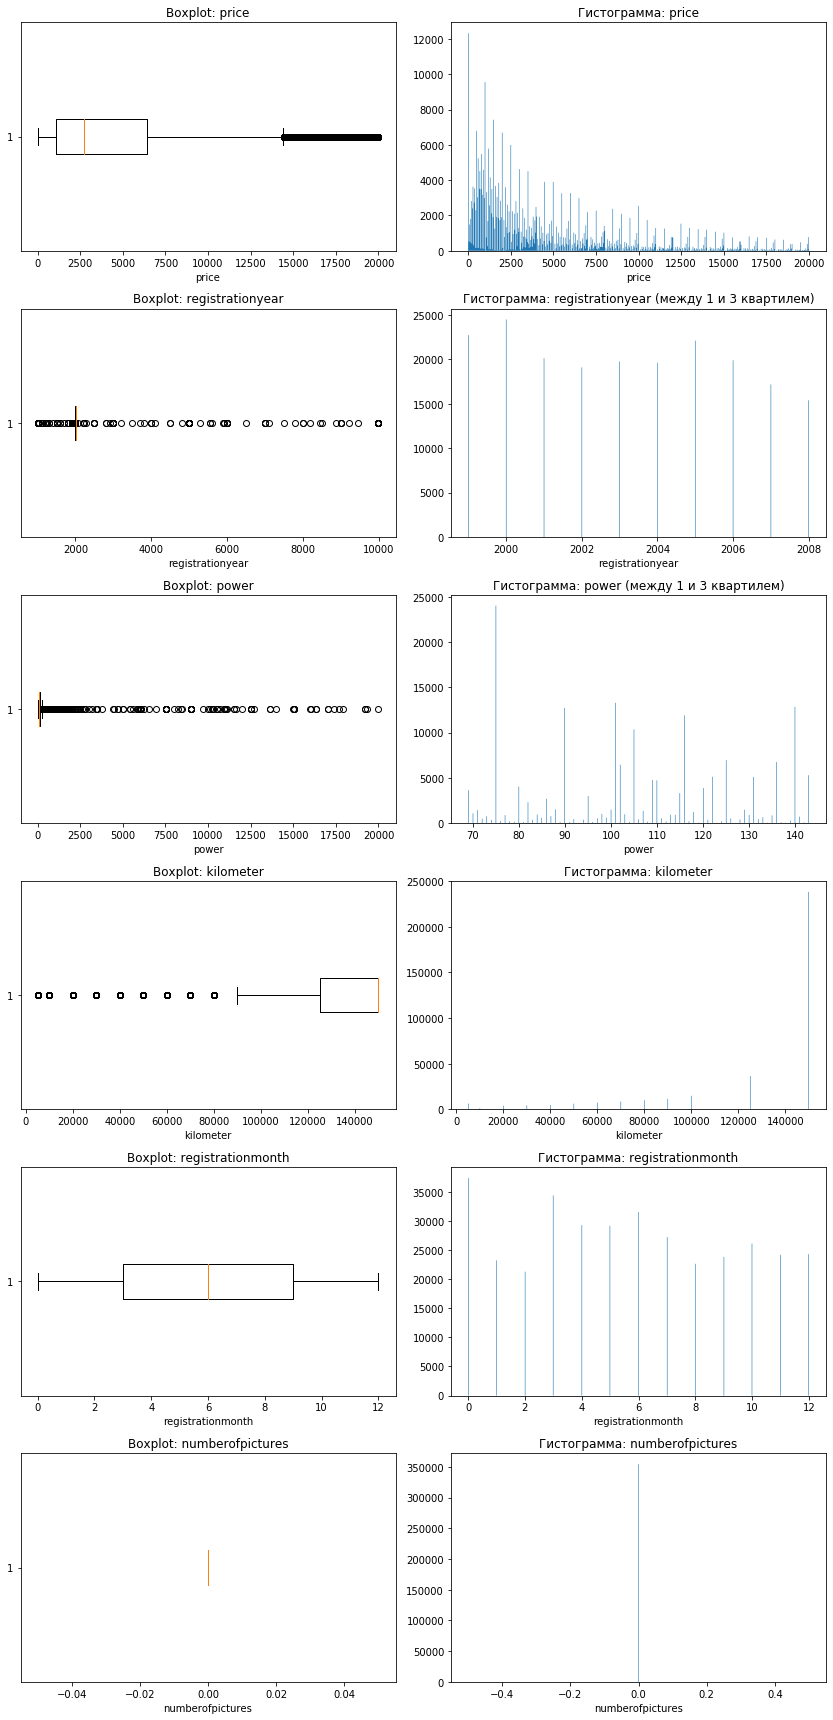

In [9]:
fig = plt.figure(figsize=(12,24))

# index строки, в которой будет отображаться текущий график
ind=0
# идем по всем количественным переменным, кроме postalcode (почтового индекса)
for col in [c for c in autos.columns if (('int' in autos[c].dtype.name) | ('float' in autos[c].dtype.name)) \
           and (c != 'postalcode')]:

    # создаем subplot
    ax = plt.subplot2grid((6,2), (ind,0))
    # рисуем boxplot
    fun_ax(ax, 'box', autos[col],
           title='Boxplot: ' + col,
           x_label=col)
       
    # создаем subplot
    ax = plt.subplot2grid((6,2), (ind,1))
    # рисуем hist
    if col in ('power', 'registrationyear'):
        # используем квартили для min и max
        fun_ax(ax, 'hist', autos[col],
               title='Гистограмма: ' + col + ' (между 1 и 3 квартилем)',
               x_label=col,
               x_range=(autos[col].quantile(0.25),
                        autos[col].quantile(0.75)))
    else:
        fun_ax(ax, 'hist', autos[col],
               title='Гистограмма: ' + col,
               x_label=col)
    
    # увеличиваем индекс строки
    ind += 1
    
fig.tight_layout()

- *Видим явные аномалии в `registrationyear` и `power`*. **Если разрабатываемое приложение перед прогнозированием цены машины будет проверять введенные данные на релистичность, то имеющиеся аномалии в исторических данных имеет смысл удалить, чтобы они не участвовали в обучении модели**.
- `power` в датасете выражается в лошадиных силах. На сегодняшний день самые мощные машины - около 5000 л.с. Поэтому всё, что выше этого значения, удалим.
- `registrationyear`:
    - Оставим минимальные значения >= q1-3iqr. Всё, что меньше, удалим.
    - Оставим максимальные значения <= 2020. Всё, что выше, удалим.
- `numberofpictures` имеет только значение 0. При построении модели не имеет смысл учиывать этот признак.

In [10]:
# минимальный год регистрации авто для удаления аномалий
# q1-3iqr
anomaly_min_registrationyear = autos.registrationyear.quantile(0.25) - 3 * \
                                (autos.registrationyear.quantile(0.75) - \
                                  autos.registrationyear.quantile(0.25))

# создаем новый df без аномальных значений registrationyear и power
autos_new = autos.query("registrationyear <= 2020 and registrationyear >= @anomaly_min_registrationyear " +
                        "and power <= 5000").copy().reset_index()

print('Длина датасета после удаления аномалий:', len(autos_new))

Длина датасета после удаления аномалий: 352341


<a id='Link6'></a>

### Изучим взаимосвязи между количественными переменными. Построим матрицу корреляции

In [11]:
# построим матрицу корреляции между количественными признаками
autos_new[['price', 'registrationyear', 'power', 'kilometer', 'registrationmonth']].corr()

,price,registrationyear,power,kilometer,registrationmonth
price,1.000000,0.421352,0.400399,-0.336835,0.110763
registrationyear,0.421352,1.000000,0.078108,-0.233896,0.037255
power,0.400399,0.078108,1.000000,0.065381,0.106577
kilometer,-0.336835,-0.233896,0.065381,1.000000,0.004202
registrationmonth,0.110763,0.037255,0.106577,0.004202,1.000000


### Вывод
 - Удалили аномальные значения в `registrationyear` и `power`
 - Изучили матрицу корреляции между количественными переменными. Отметили:
   - положительную корреляцию между `price` и `registrationyear`
   - положительную корреляцию между `price` и `power`
   - слабую отрицательную корреляцию между `price` и `kilometer`
   - слабую отрицательную корреляцию между `registrationyear` и `kilometer`
   - **мультиколлинеарности и утечки целевого признака не наблюдаем**

## 4. Подготовка признаков для построения моделей

<a id='Link7'></a>

### Признаки, которые будут участвовать в построении модели для прогонозирования целевого признака `price`: `vehicletype`, `registrationyear`, `gearbox`, `power`, `model`, `kilometer`, `registrationmonth`, `fueltype`, `brand`, `notrepaired`

#### Определяем список категориальных `category_columns`, закодированных  категориальных `category_coded_columns`, и количественных `numeric_columns` признаков

In [12]:
# определяем список категориальных признаков
category_columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

# определяем список закодированных категориальных признаков
# методом Порядковое кодирование
category_columns_ordinal = [c + '_ordinal' for c in category_columns]

# определим список закодированных категориальных признаков
# методом Прямое кодирование OHE
# названия столбцов внесем после преобразования OHE
category_columns_ohe = []

# определяем список количественных признаков
numeric_columns = ['registrationyear', 'power', 'kilometer', 'registrationmonth']

### **Порядковое кодирование**

In [13]:
# создем объкет для кодирования
encoder = OrdinalEncoder()
# преобразуем категориальные признаки
encoder.fit(autos_new[category_columns])

# создаем новый DF с:
# - преобразованными категориальными признаками
# - оригинальными категориальными признаками
# - количественными признаками
autos_new_coded = pd.concat([pd.DataFrame(encoder.transform(autos_new[category_columns]),
                                          columns = category_columns_ordinal),
                             autos_new[category_columns + numeric_columns + ['price']]], axis=1)

# переводим в int все преобразованные категориальные признаки
for col in category_columns_ordinal:
    autos_new_coded[col] = autos_new_coded[col].astype('int64')

# переводим в category все оригинальные категориальные признаки
for col in category_columns:
    autos_new_coded[col] = autos_new_coded[col].astype('category')    

# проверяем типы данных
print('\nПроверяем типы данных категориальных признаков и закодированных категориальных признаков:\n')
print(autos_new_coded[category_columns + category_columns_ordinal].dtypes)

# проверяем преобразование
print('\nПровели порядковое кодирование категориальных признаков. Проверим:\n')
print('Признаки ДО порядкового кодирования')
display(autos_new_coded[category_columns].head(5))
print('\nПризнаки ПОСЛЕ порядкового кодирования')
display(autos_new_coded[category_columns_ordinal].head(5))


Проверяем типы данных категориальных признаков и закодированных категориальных признаков:

vehicletype            category
gearbox                category
model                  category
fueltype               category
brand                  category
notrepaired            category
vehicletype_ordinal       int64
gearbox_ordinal           int64
model_ordinal             int64
fueltype_ordinal          int64
brand_ordinal             int64
notrepaired_ordinal       int64
dtype: object

Провели порядковое кодирование категориальных признаков. Проверим:

Признаки ДО порядкового кодирования


,vehicletype,gearbox,model,fueltype,brand,notrepaired
0,unknown,manual,golf,petrol,volkswagen,unknown
1,coupe,manual,unknown,gasoline,audi,yes
2,suv,auto,grand,gasoline,jeep,unknown
3,small,manual,golf,petrol,volkswagen,no
4,small,manual,fabia,gasoline,skoda,no



Признаки ПОСЛЕ порядкового кодирования


,vehicletype_ordinal,gearbox_ordinal,model_ordinal,fueltype_ordinal,brand_ordinal,notrepaired_ordinal
0,7,1,116,6,38,1
1,2,1,228,2,1,2
2,6,0,117,2,14,1
3,5,1,116,6,38,0
4,5,1,101,2,31,0


### Прямое кодирование OHE

In [14]:
# применяем OHE
autos_ohe = pd.get_dummies(autos_new[category_columns], drop_first=True)

# сохраняем список столбцов, закодированных через OHE, добавляем "_ohe"
category_columns_ohe = [c + '_ohe' for c in autos_ohe.columns]
# обновляем названия столбцов в самом telecom_ohe
autos_ohe.columns = category_columns_ohe

# добавляем autos_ohe к autos_new_coded
autos_new_coded = autos_new_coded.join(autos_ohe)

print('Список закодированных категориальных признаков методом прямого кодирования OHE (первые 10):')
display(category_columns_ohe[:10])

# проверяем типы данных
print('\nПроверяем типы данных закодированных категориальных признаков (первые 10):\n')
print(autos_new_coded[category_columns_ohe].dtypes[:10])
    
# проверяем преобразование
print('\nПровели прямое кодирование OHE категориальных признаков. Проверим:\n')
print('Признаки ДО прямого кодирования OHE')
display(autos_new_coded[category_columns].head(5))
print('\nПризнаки ПОСЛЕ прямого кодирования OHE')
display(autos_new_coded[category_columns_ohe].head(5))

Список закодированных категориальных признаков методом прямого кодирования OHE (первые 10):


['vehicletype_convertible_ohe',
 'vehicletype_coupe_ohe',
 'vehicletype_other_ohe',
 'vehicletype_sedan_ohe',
 'vehicletype_small_ohe',
 'vehicletype_suv_ohe',
 'vehicletype_unknown_ohe',
 'vehicletype_wagon_ohe',
 'gearbox_manual_ohe',
 'gearbox_unknown_ohe']


Проверяем типы данных закодированных категориальных признаков (первые 10):

vehicletype_convertible_ohe    uint8
vehicletype_coupe_ohe          uint8
vehicletype_other_ohe          uint8
vehicletype_sedan_ohe          uint8
vehicletype_small_ohe          uint8
vehicletype_suv_ohe            uint8
vehicletype_unknown_ohe        uint8
vehicletype_wagon_ohe          uint8
gearbox_manual_ohe             uint8
gearbox_unknown_ohe            uint8
dtype: object

Провели прямое кодирование OHE категориальных признаков. Проверим:

Признаки ДО прямого кодирования OHE


,vehicletype,gearbox,model,fueltype,brand,notrepaired
0,unknown,manual,golf,petrol,volkswagen,unknown
1,coupe,manual,unknown,gasoline,audi,yes
2,suv,auto,grand,gasoline,jeep,unknown
3,small,manual,golf,petrol,volkswagen,no
4,small,manual,fabia,gasoline,skoda,no



Признаки ПОСЛЕ прямого кодирования OHE


,vehicletype_convertible_ohe,vehicletype_coupe_ohe,vehicletype_other_ohe,vehicletype_sedan_ohe,vehicletype_small_ohe,vehicletype_suv_ohe,vehicletype_unknown_ohe,vehicletype_wagon_ohe,gearbox_manual_ohe,gearbox_unknown_ohe,...,brand_smart_ohe,brand_sonstige_autos_ohe,brand_subaru_ohe,brand_suzuki_ohe,brand_toyota_ohe,brand_trabant_ohe,brand_volkswagen_ohe,brand_volvo_ohe,notrepaired_unknown_ohe,notrepaired_yes_ohe
0,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,1,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


<a id='Link8'></a>

### Разделим датасет на обучающую и тестовую выборки

In [15]:
# выделим фичи и целевой признак
features = autos_new_coded.drop('price', axis=1)
target = autos_new_coded['price']

# делам сплит на обучающую и тестовую выборки
train_features, test_features, train_target, test_target = \
            train_test_split(features, target, test_size=0.25, random_state=12345)
   
# выводим размеры выборок
print('Длина исходного датасета:', len(autos_new_coded))
print('Длина обучающей выборки:', len(train_features))
print('Длина тестовой выборки:', len(test_features))
print('Проверка общей длины обучающей + тестовой:', len(train_features) + len(test_features))

Длина исходного датасета: 352341
Длина обучающей выборки: 264255
Длина тестовой выборки: 88086
Проверка общей длины обучающей + тестовой: 352341


<a id='Link9'></a>

### Масштабируем количественные признаки

In [16]:
# масштабируем количественные признаки
    
display('Количественные признаки ДО масштабирования признаков:',
        train_features[numeric_columns].head(5))
    
# создаем объект структуры StandardScaler() и настраиваем его на обучающих данных
scaler = StandardScaler()
scaler.fit(train_features[numeric_columns])

# масштабируем количественные признаки в обучающей выборке
train_features.loc[:, numeric_columns] = scaler.transform(train_features[numeric_columns])
    
# масштабируем количественные признаки в тестовой выборке
test_features.loc[:, numeric_columns] = scaler.transform(test_features[numeric_columns])
    
display('Количественные признаки ПОСЛЕ масштабирования признаков:',
        train_features[numeric_columns].head(5))

'Количественные признаки ДО масштабирования признаков:'

,registrationyear,power,kilometer,registrationmonth
269187,2009,129,150000,1
164715,1999,64,150000,11
64512,2006,163,30000,3
187974,2004,204,150000,1
303688,1999,125,150000,8


'Количественные признаки ПОСЛЕ масштабирования признаков:'

,registrationyear,power,kilometer,registrationmonth
269187,0.831607,0.279930,0.572297,-1.269704
164715,-0.627650,-0.575117,0.572297,1.417001
64512,0.393830,0.727186,-2.620601,-0.732363
187974,0.101979,1.266523,0.572297,-1.269704
303688,-0.627650,0.227312,0.572297,0.610989


### Вывод
- Закодировали категориальные признаки
- Разделили датасет на обучающую и тестовую выборки
- Масштабировали количественные признаки

## 5. Построение моделей

In [17]:
# функция для расчета RMSE
fun_rmse = lambda target, predictions: \
           mean_squared_error(np.array(target), predictions) ** 0.5

# задаем свой score через функцию
score_rmse = make_scorer(fun_rmse, greater_is_better=False)

In [18]:
def fun_build_model(model, model_name, parametrs, features, target, cv, params_fit):
    """функция для построения модели,
    обучает модель, подбирает лучшие параметры,
    использует кросс-валидацию и скор = score_rmse
    
    на входе:
     - структура модели
     - наименование
     - словарь параметров, по которым нужно определить лучшую модель
     - список фичей
     - таргет
     - кол-во сплитов при кросс-валидации
     - параметры для обучения
    
    на выходе:
     - результат работы метода GridSearchCV
    """
    
    # передаем модель и параметры
    grid= GridSearchCV(model, parametrs, scoring=score_rmse, n_jobs=-1, cv=cv)
    
    # обучаем модель
    grid.fit(features, target, **params_fit)

    # выводим лучшую модель, лучшие параметры и лучший скор
    print('Лучшая модель {}:'.format(model_name))
    display(grid.best_estimator_)
    print('Лучшие параметры модели:')
    display(grid.best_params_)
    print('Лучший RMSE: {}\n'.format(grid.best_score_.round(4)))
    # выводим время обучения полного датасета
    print('Время обучения полного обучающего датасета после получения лучших параметров: {:.3f} сек\n'
      .format(grid.refit_time_))
    
    #возвращаем grid
    return grid

In [19]:
def features_importances(model, col_names, model_name):
    """функция для вывода весов признаков при построении модели
    
    на входе:
     - модель
    
    на выходе:
     - вывод весов признаков
    """
    # создаем DF из feature_importances модели
    feature_importances = model.feature_importances_
    feature_importances_df = pd.DataFrame({'features': col_names, 'feature_importances': feature_importances})
   
    # рисуем bar
    fig = plt.figure(figsize=(12,5))
    ax = plt.subplot(111)
    fun_ax(ax, 'bar',
           feature_importances_df.sort_values('feature_importances', ascending=False).features,
           feature_importances_df.sort_values('feature_importances', ascending=False).feature_importances,
          'Веса признаков при построении модели {}'.format(model_name),
           x_label='Признаки', y_label='Веса',
           color='orange')
    plt.xticks(rotation=90)
    fig.tight_layout()

<a id='Link10'></a>

### Модель Линейная регрессия

In [20]:
%%time
# формируем параметры для поиска лучшей модели
params_grid = {}

# строим модель Линейная регрессия
grid_linear_regression = fun_build_model(LinearRegression(),
                                         'Линейная регрессия',
                                         params_grid,
                                         # передаем закодированные категориальные признаки
                                         # методом прямого кодирования ohe
                                         train_features[category_columns_ohe + numeric_columns],
                                         train_target, cv=3, params_fit={})

Лучшая модель Линейная регрессия:


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Лучшие параметры модели:


{}

Лучший RMSE: -2735.5452

Время обучения полного обучающего датасета после получения лучших параметров: 4.971 сек

Wall time: 30.1 s


<a id='Link11'></a>

### Модель Дерево решений

Лучшая модель Дерево решений:


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=12345, splitter='best')

Лучшие параметры модели:


{'max_depth': 13}

Лучший RMSE: -2074.7933

Время обучения полного обучающего датасета после получения лучших параметров: 0.865 сек

Wall time: 7.22 s


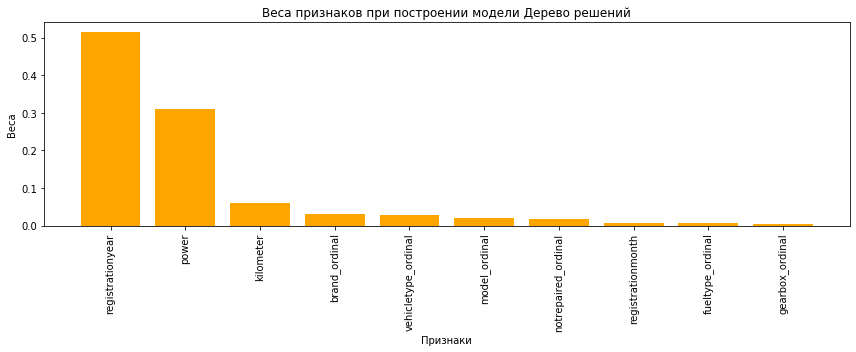

In [21]:
%%time
# формируем параметры для поиска лучшей модели
params_grid = {'max_depth': range(1,20,2)}

# строим модель Дерево решений
grid_tree_regressor = fun_build_model(DecisionTreeRegressor(random_state=12345),
                                      'Дерево решений',
                                      params_grid,
                                      # передаем закодированные категориальные признаки
                                      # методом порядкового кодирования
                                      train_features[category_columns_ordinal + numeric_columns],                                     
                                      train_target, cv=3, params_fit={})

# смотрим веса признаков при построении модели
features_importances(grid_tree_regressor.best_estimator_,
                     category_columns_ordinal + numeric_columns,
                     'Дерево решений')

<a id='Link12'></a>

### Модель Случайный лес

Лучшая модель Случайный лес:


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=12345, verbose=0, warm_start=False)

Лучшие параметры модели:


{'max_depth': 10, 'n_estimators': 50}

Лучший RMSE: -1989.6983

Время обучения полного обучающего датасета после получения лучших параметров: 27.067 сек

Wall time: 5min 26s


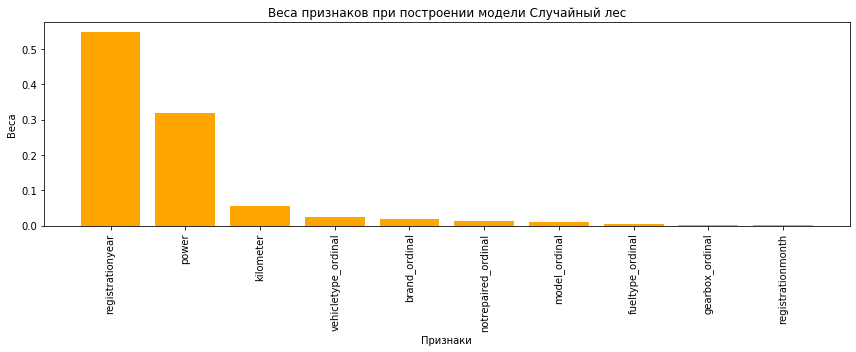

In [22]:
%%time
# формируем параметры для поиска лучшей модели
params_grid = {'max_depth': range(1,11,1),
               'n_estimators': range(10,51,10)}

# строим модель Случайный лес
grid_forest_regressor = fun_build_model(RandomForestRegressor(random_state=12345),
                                        'Случайный лес',
                                        params_grid,
                                        # передаем закодированные категориальные признаки
                                        # методом порядкового кодирования
                                        train_features[category_columns_ordinal + numeric_columns],
                                        train_target, cv=3, params_fit={})

# смотрим веса признаков при построении модели
features_importances(grid_forest_regressor.best_estimator_,
                     category_columns_ordinal + numeric_columns,
                     'Случайный лес')

<a id='Link13'></a>

### Модель градиентный бустинг LGBMRegressor

Лучшая модель Градиентный бустинг LightGBM:


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.4, max_depth=5,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_iterations=100, num_leaves=20,
              objective=None, random_state=12345, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

Лучшие параметры модели:


{'learning_rate': 0.4, 'max_depth': 5}

Лучший RMSE: -1758.1921

Время обучения полного обучающего датасета после получения лучших параметров: 1.002 сек

Wall time: 55.8 s


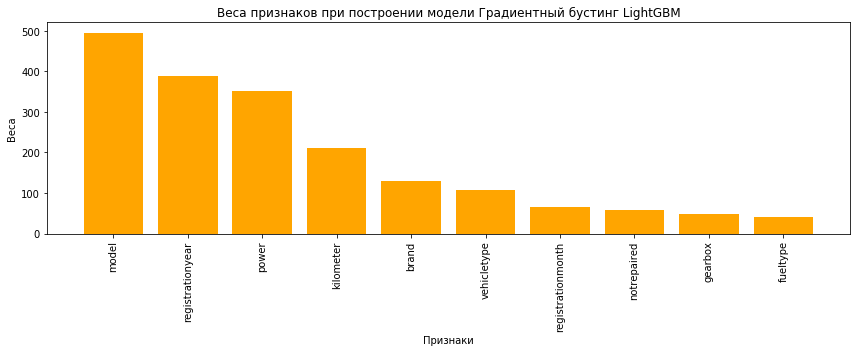

In [23]:
%%time
# формируем параметры для обучения
params_fit = {'categorical_feature': category_columns}

# формируем параметры для поиска лучшей модели
params_grid = {'max_depth': range(1,6,1),
               'learning_rate': np.arange(0.1,1,0.1)}

#формируем параметры для создания модели
params_model = {'num_iterations': 100,
                'num_leaves': 20,
                'random_state': 12345}
    
#задаем модель LGBMRegressor
model_lgb = lgb.LGBMRegressor(**params_model)

#строим модель Градиентный бустинг
grid_lgb = fun_build_model(model_lgb, 'Градиентный бустинг LightGBM', params_grid,
                           # передаем оригинальные категориальные признаки
                           train_features[category_columns + numeric_columns],
                           train_target, cv=3, params_fit=params_fit)

# смотрим веса признаков при построении модели
features_importances(grid_lgb.best_estimator_,
                     category_columns + numeric_columns,
                     'Градиентный бустинг LightGBM')

<a id='Link14'></a>

### Модель градиентный бустинг CatBoostRegressor

Лучшая модель Градиентный бустинг CatBoost:


Лучшие параметры модели:


{'learning_rate': 0.7000000000000001, 'max_depth': 5}

Лучший RMSE: -1814.5325

Время обучения полного обучающего датасета после получения лучших параметров: 6.001 сек

Wall time: 6min 34s


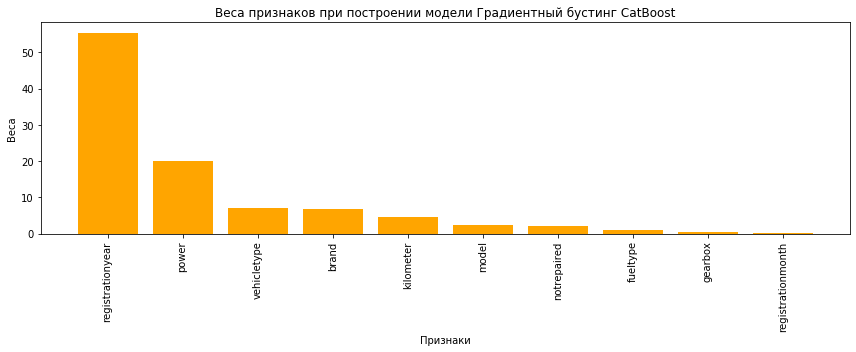

In [24]:
%%time
# формируем параметры для обучения
params_fit = {'cat_features': category_columns,
              'verbose': False}

# формируем параметры для поиска лучшей модели
params_grid = {'max_depth': range(1,6,1),
               'learning_rate': np.arange(0.1,1,0.1)}

# формируем параметры для создания модели
params_model = {'iterations': 100,
                'random_state': 12345}
    
# задаем модель CatBoostRegressor
model_cat = CatBoostRegressor(**params_model)

# строим модель Градиентный бустинг
grid_cat = fun_build_model(model_cat, 'Градиентный бустинг CatBoost', params_grid,
                           # передаем оригинальные категориальные признаки
                           train_features[category_columns + numeric_columns],
                           train_target, cv=3, params_fit=params_fit)

# смотрим веса признаков при построении модели
features_importances(grid_cat.best_estimator_,
                     category_columns + numeric_columns,
                     'Градиентный бустинг CatBoost')

<a id='Link15'></a>

### Модель градиентный бустинг XGBoostRegressor

Лучшая модель Градиентный бустинг XGBoost:


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.5, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.5, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=12345, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Лучшие параметры модели:


{'eta': 0.5, 'max_depth': 5}

Лучший RMSE: -1778.967

Время обучения полного обучающего датасета после получения лучших параметров: 6.110 сек

Wall time: 5min 46s


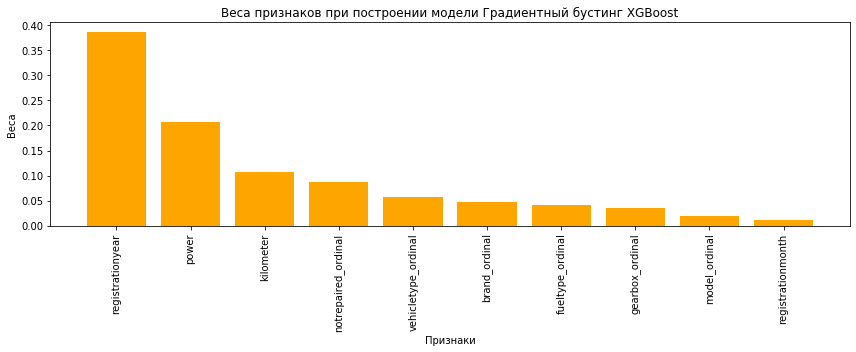

In [25]:
%%time
# формируем параметры для обучения
params_fit = {'verbose': 0}

# формируем параметры для поиска лучшей модели
params_grid = {'max_depth': range(1,6,1),
               'eta': np.arange(0.1,1,0.1)}

# формируем параметры для создания модели
params_model = {'n_estimators': 100,
                'random_state': 12345}
    
# задаем модель XGBRegressor
model_xgb = XGBRegressor(**params_model)

# строим модель Градиентный бустинг
grid_xgb = fun_build_model(model_xgb, 'Градиентный бустинг XGBoost', params_grid,
                           # передаем закодированные категориальные признаки
                           # методом порядкового кодирования
                           train_features[category_columns_ordinal + numeric_columns], train_target,
                           cv=3, params_fit=params_fit)

# смотрим веса признаков при построении модели
features_importances(grid_xgb.best_estimator_,
                     category_columns_ordinal + numeric_columns,
                     'Градиентный бустинг XGBoost')

## 6. Анализ моделей

<a id='Link16'></a>

###  Проверим модели на тестовой выборке и рассчитаем скорость предсказания

In [26]:
def fun_check_by_test(model, model_name, features, target, ax):
    """функция для проверки модели на тестовой выборке
    делает предсказания по переданной модели и
    рассчитывает RMSE, выводит scatter предсказаний и таргета
    
    параметры:
     - модель и название модели,
     - признаки, таргет
     - ax для диаграммы рассеяния (таргет, предсказания)
    """
     
    # предсказания на тестовой выборке
    # засекаем время предсказания
    start_time = perf_counter()
    predictions = model.predict(features)
    stop_time = perf_counter()
    
    # рисуем scatter между таргетом и пресказаниями
    fun_ax(ax, 'scatter', target, predictions,
          'Диаграмма рассеяния.\nМодель - {}.\nRMSE на test: {:.2f}.\nВремя предсказания: {:.3f} s'
           .format(model_name, fun_rmse(target, predictions), stop_time - start_time),
           x_label='Целевой признак (таргет)', y_label='Предсказания таргета',
           color='orange')

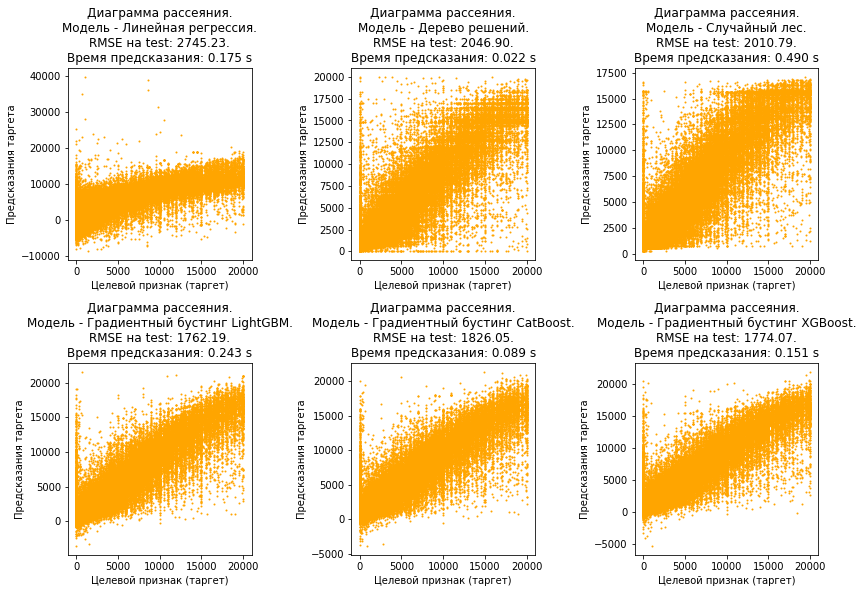

In [27]:
fig = plt.figure(figsize=(12,12))

# Линейная регрессия
ax = plt.subplot(331)
fun_check_by_test(grid_linear_regression.best_estimator_,
                  'Линейная регрессия',
                  # передаем закодированные категориальные признаки
                  test_features[category_columns_ohe + numeric_columns],
                  test_target, ax)

# Дерево решений
ax = plt.subplot(332)
fun_check_by_test(grid_tree_regressor.best_estimator_,
                  'Дерево решений',
                  # передаем закодированные категориальные признаки
                  test_features[category_columns_ordinal + numeric_columns],
                  test_target, ax)

# Случайный лес
ax = plt.subplot(333)
fun_check_by_test(grid_forest_regressor.best_estimator_,
                  'Случайный лес',
                  # передаем закодированные категориальные признаки
                  test_features[category_columns_ordinal + numeric_columns],
                  test_target, ax)

# Градиентный бустинг LightGBM
ax = plt.subplot(334)
fun_check_by_test(grid_lgb.best_estimator_,
                  'Градиентный бустинг LightGBM',
                  # передаем оригинальные категориальные признаки
                  test_features[category_columns + numeric_columns],
                  test_target, ax)

# Градиентный бустинг CatBoost
ax = plt.subplot(335)
fun_check_by_test(grid_cat.best_estimator_,
                  'Градиентный бустинг CatBoost',
                  # передаем оригинальные категориальные признаки
                  test_features[category_columns + numeric_columns],
                  test_target, ax)


# Градиентный бустинг XGBoost
ax = plt.subplot(336)
fun_check_by_test(grid_xgb.best_estimator_,
                  'Градиентный бустинг XGBoost',
                  # передаем закодированные категориальные признаки
                  test_features[category_columns_ordinal + numeric_columns],
                  test_target, ax)

fig.tight_layout()

<a id='Link17'></a>

### Проверим модели на вменяемость. Посчитаем `RMSE` у константной модели по предсказаниям среднего `price`

In [28]:
# проверяем на вменяемость
# делаем серию из среднего price обучающей выборки
predictions_mean = pd.Series(train_target.mean(),
                                index=test_target.index)
print('RMSE константной модели на тестовой выборке: {:.2f}'.format(fun_rmse(test_target, predictions_mean)))

RMSE константной модели на тестовой выборке: 4507.78


- ***Все модели прошли проверку на вменяемость***

<a id='Link18'></a>

### Анализ моделей

#### *Качество моделей на тестовой выборке:*
- *Линейная регрессия*: **RMSE = 2745**
- *Дерево решений*: **RMSE = 2047**
- *Случайный лес*: **RMSE = 2011**
- *Градиентный бустинг LightGBM*: **RMSE = 1762**
- *Градиентный бустинг CatBoost*: **RMSE = 1826**
- *Градиентный бустинг XGBoost*: **RMSE = 1774**


#### *Скорость предсказания на тестовой выборке:*
- *Линейная регрессия*: **0,2** сек
- *Дерево решений*: **0,02** сек
- *Случайный лес*: **0,5** сек
- *Градиентный бустинг LightGBM*: **0,2** сек
- *Градиентный бустинг CatBoost*: **0,1** сек
- *Градиентный бустинг XGBoost*: **0,2** сек


#### *Время обучения полного обучающего датасета после получения лучших параметров:*
- *Линейная регрессия*: **5** сек
- *Дерево решений*: **0,9** сек
- *Случайный лес*: **27** сек
- *Градиентный бустинг LightGBM*: **1** сек
- *Градиентный бустинг CatBoost*: **6** сек
- *Градиентный бустинг XGBoost*: **6** сек


**Самая лучшая модель по качеству среди простых моделей - Случайный лес**.

**Самые лучшие модели по качеству среди всех моделей - Градиентный бустинг LightGBM и Градиентный бустинг XGBoost**, при этом скорость предсказания у обеих моделей одинаковая, но скорость обучения у LightGBM гораздо лучше.

**Самая худшая модель по качеству - Линейная регрессия**.

**Медленнее всех обучается Случайный лес**.

Почти у всех моделей наибольший вес имеют признаки: `registrationyear`, `power`, `kilometer`. Но LGBMRegressor поставила на первое место признак `model`. Самыми "невостребованными" оказались признаки: `registrationmonth`, `gearbox`, `fueltype`.

<a id='Link19'></a>

## 7. Общий вывод



 - *Изучили общую информацию*
    - Обнаружили *пропуски в категориальных признаках*: `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`



 - *Предобработали данные*
    - Заменили названия столбцов
    - Заменили типы данных
    - *Все пропуски в категориальных признаках заменили на unknown*
    - Удалили строки-дубликаты



 - *Провели исследовательский анализ данных*
   - Удалили аномальные значения в `registrationyear` и `power`
   - Изучили матрицу корреляции между количественными переменными. Отметили:
      - положительную корреляцию между `price` и `registrationyear`
      - положительную корреляцию между `price` и `power`
      - слабую отрицательную корреляцию между `price` и `kilometer`
      - слабую отрицательную корреляцию между `registrationyear` и `kilometer`
      - **мультиколлинеарности и утечки целевого признака не обнаружили**



 - *Подготовили признаки для построения модели*
   - Закодировали категориальные признаки
   - Разделили датасет на обучающую и тестовую выборки
   - Масштабировали количественные признаки



 - *Построили модели:* **Линейная регрессия, Дерево решений, Случайный лес, Градиентный бустинг LightGBM, Градиентный бустинг CatBoost, Градиентный бустинг XGBoost**



 - *Провели анализ моделей*
   - Проверили модели на тестовой выборке
   - Проверили модели на вменяемость
   - Сравнили качество, скорость предсказания, время обучения всех моделей, а также веса признаков при построении моделей



 - **Вывод**
  - **Самая лучшая модель по качеству среди простых моделей - Случайный лес**.

  - **Самые лучшие модели по качеству среди всех моделей - Градиентный бустинг LightGBM и Градиентный бустинг XGBoost**, при этом скорость предсказания у обеих моделей одинаковая, но скорость обучения у LightGBM гораздо лучше.

  - **Самая худшая модель по качеству - Линейная регрессия**.

  - **Медленнее всех обучается Случайный лес**.

  - Почти у всех моделей наибольший вес имеют признаки: `registrationyear`, `power`, `kilometer`. Но LGBMRegressor поставила на первое место признак `model`. Самыми "невостребованными" оказались признаки: `registrationmonth`, `gearbox`, `fueltype`.


  - **Для предсказания цены в приложении будем использовать модель Градиентный бустинг LightGBM, которая имеет лучшие характеристики по качеству и скорости обучения и хорошую скорость предсказания**.